In [1]:
import numpy as np
import time
import json
from copy import deepcopy as dc
import torch

import joblib
import re

%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from data.utils import votes_filter, plot_overlap_conflict
from data.agnews.utils import load_data, get_inst

In [2]:
label_idx = [0,1,2,3]


train = load_data('train')
dev = load_data('dev')
test = load_data('test')

In [3]:
from nplm.plf import WeakRule, BinaryRERules, regex_decision

train_instances, _ = get_inst(train)
dev_instances, dev_labels = get_inst(dev)

In [4]:
def df1(instance):
    entity_doc = instance['sen_ner']
    if 'EVENT' in  entity_doc and 'GPE' in entity_doc:
        return 1
    return -1

gpe_event_title = WeakRule(name='gpe+event_title', exec_module=df1, label_maps={0:[0,2,3], 1:[1]})


v1 = gpe_event_title.execute(dev_instances)
acc, p, r, cwacc = gpe_event_title.eval(dev_labels, class_wise_acc=True)
print(acc, p, r)
print(cwacc)


def df2(instance):
    entity_doc = instance['title_ner']
    if 'LOC' in entity_doc:
        return 1
    return -1

loc_title_rule = WeakRule(name='loc_title', exec_module=df2, label_maps={0:[1,2,3], 1:[0]})

v1 = loc_title_rule.execute(dev_instances)
acc, p, r, cwacc = loc_title_rule.eval(dev_labels, class_wise_acc=True)
print(acc, p, r)
print(cwacc)



sports_names = 'kelvim escobar|red sox|formula one|grand prix|svetlana kuznetsova|billy wagner| kobe | beckham|johnny damon|robin ventura|olivier panis'

sp0 = BinaryRERules(name='sports_names',re_pattern=sports_names, 
                                 preproc=lambda inst:inst['sen_lemma'].lower(), 
                                 label_maps={0:[0,2,3], 1:[1]}, unipolar=True)
v5 = sp0.execute(dev_instances)

acc, p, r, cwacc = sp0.eval(dev_labels, class_wise_acc=True)
print(acc, p, r)
print(cwacc)


def bexclusive_lemmas(instance):

    business_keywords = {'profit', 'bankrupt', 'yen', 'financial'}
    
    doc = instance['sen_lemma'].lower().split()
    
    for word in doc:
        for keyword in business_keywords:
            if word.startswith(keyword):
                return 1
    return -1


bexclusive_lemmas_rule = WeakRule(name='bus_lemma', exec_module=bexclusive_lemmas, label_maps={0:[0,1,3], 1:[2]})
v1 = bexclusive_lemmas_rule.execute(dev_instances)
acc, p, r, cwacc = bexclusive_lemmas_rule.eval(dev_labels, class_wise_acc=True)
print(acc, p, r)
print(cwacc)


tech = 'space.com|space station|network authentication|(python|java|matlab|c) developer|application|virus|browser hijack|search engine|internet-based|windows update|smart phone|source code|mangement software|software.*develop|internet connection|interactive gam|game console|transfer datum|internet security|g network|internet company|storage capacity|music player|microsystem|comsumer electronic|operat.*system|wireness network|motherboard|spacecraft|malicious program|video game'

techr = BinaryRERules(name='tech_terms',re_pattern=tech, 
                                 preproc=lambda inst:inst['sen_lemma'].lower(), 
                                 label_maps={0:[0,1,2], 1:[3]}, unipolar=True)
v5 = techr.execute(dev_instances)

acc, p, r, cwacc = techr.eval(dev_labels, class_wise_acc=True)
print(acc, p, r)
print(cwacc)


def exclusive_lemmas(instance):
    
    
    world_pol_keywords = {'mideast', 'iraq', 'baghdad', 'pakistan', 'afghan',
                          'kurd', 'arab' 'egypt', 'iran', 'turkey', 'syria', 'bahrain',
                          'israel', 'jordan', 'kuwait', 'lebanon', 'oman', 'palestine',
                          'qatar', 'saudi', 'uae', 'yemen' ,'chechnya'}
    
    
    world_pol_keywords |= {'al-qaeda', 'taliban'}
    world_pol_keywords |= {'hostage', 'abduct', 'hijack'}
    world_pol_keywords |= {'invasion', ' coup ', 'curfew', 'army', 'troop', 'peace', 'militant', 'missile'}
    world_pol_keywords |= {'murder', 'death'}
#     world_pol_keywords |= {'typhoon'}
    
    sports_keywords = {'baseball', 'football', 'soccer', 'hockey', 'basketball', 'tennis', 'golf'}
    sports_keywords |= {'stadium', 'arena'}
    sports_keywords |= {'season', 'playoff', 'tournament'}
    sports_keywords |= {'mlb', 'nfl', 'nba', 'mls', 'nhl', 'ncaa', 'league', 'racing'}
    sports_keywords |= {'premiership'}
    sports_keywords |= {'quarterback', 'centerback', 'fullback', 'pitcher'}
    
    business_keywords = {'profit', 'bankrupt', 'financial'}
    
    bt_keywords = {'robot', 'robotic'}
    bt_keywords |= {'web', 'internet'}
    bt_keywords |= {'linux'}
    bt_keywords |= {'stem-cell', 'biotechnology'}
    bt_keywords |= {'xbox', 'playstation'}
    bt_keywords |= {'microsoft'}
    bt_keywords |= {'space', 'nasa'}
    bt_keywords |= {'adobe', 'ipod', 'apple', 'xerox', 'ibm'}
    
    
    doc = instance['sen_lemma'].lower().split()
    
    for word in doc:
        for keyword in bt_keywords:
            if word.startswith(keyword):
                return 3
            
    for word in doc:
        for keyword in world_pol_keywords:
            if word.startswith(keyword):
                return 0

    for word in doc:
        for keyword in sports_keywords:
            if word.startswith(keyword):
                return 1
            
    for word in doc:
        for keyword in business_keywords:
            if word.startswith(keyword):
                return 2
            


    
    return -1

exclusive_lemmas_rule = WeakRule(exec_module=exclusive_lemmas, label_maps={0:[0], 1:[1], 2:[2], 3:[2,3]})
v1 = exclusive_lemmas_rule.execute(dev_instances)
acc, p, r, cwacc = exclusive_lemmas_rule.eval(dev_labels, class_wise_acc=True)


def df3(instance):
    entity_doc = instance['title_ner']
#     print(entity_doc)
    if 'PERSON' in  entity_doc and 'GPE' in entity_doc:
        return 1
    return -1

person_gpe_title_rule = WeakRule(name='p+gpe_title', exec_module=df3, label_maps={0:[2, 3], 1:[0, 1]})

def df4(instance):
    entity_doc = instance['sen_ner']
#     print(entity_doc)
    if 'PERSON' in  entity_doc and 'EVENT' in entity_doc:
        return 1
    return -1

person_event_sen_rule = WeakRule(name='person+event_sen', exec_module=df4, label_maps={0:[2,3], 1:[0,1]})


v1 = person_event_sen_rule.execute(dev_instances)
acc, p, r, cwacc = person_event_sen_rule.eval(dev_labels, class_wise_acc=True)
print(acc, p, r)
print(cwacc)

def df5(instance):
    entity_doc = instance['title_ner']
    if  'PRODUCT' in entity_doc:
        return 1
    return -1

sen_prod_t_rule = WeakRule(exec_module=df5, label_maps={0:[0,1], 1:[2,3]})

v1 = sen_prod_t_rule.execute(dev_instances)
acc, p, r, cwacc = sen_prod_t_rule.eval(dev_labels, class_wise_acc=True)
print(acc, p, r)
print(cwacc)



test_patt = 'minister|chairman'
dpw2 = BinaryRERules(name='dpw2',
                     re_pattern=test_patt, 
                                 preproc=lambda inst:inst['sen_lemma'].lower(), 
                                 label_maps={0:[1,3], 1:[0,2]}, unipolar=True)
v5 = dpw2.execute(dev_instances)

acc, p, r, cwacc = dpw2.eval(dev_labels, class_wise_acc=True)
print(acc, p, r)
print(cwacc)


intn = 'internet'

intnr = BinaryRERules(name='tech',re_pattern=intn, 
                                 preproc=lambda inst:inst['sen_lemma'].lower(), 
                                 label_maps={0:[1,2], 1:[0,3]}, unipolar=True)
v5 = intnr.execute(dev_instances)

acc, p, r, cwacc = intnr.eval(dev_labels, class_wise_acc=True)
print(acc, p, r)
print(cwacc)

0.7142857142857143 0.7142857142857143 0.03
[0.0, 1.0, 0.0, 0.0]
0.8333333333333334 0.8333333333333334 0.01
[1.0, nan, nan, 0.0]
0.8888888888888888 0.8888888888888888 0.016
[0.0, 1.0, nan, nan]
0.9230769230769231 0.9230769230769231 0.024
[nan, nan, 1.0, 0.0]
0.9523809523809523 0.9523809523809523 0.04
[nan, nan, 0.0, 1.0]
1.0 1.0 0.044
[1.0, 1.0, nan, nan]
1.0 1.0 0.014
[nan, nan, 1.0, 1.0]
0.9642857142857143 0.9642857142857143 0.054
[1.0, nan, 1.0, 0.0]
1.0 1.0 0.03
[1.0, nan, nan, 1.0]


In [5]:
from nplm.plf import executor, evaluator

plfs = [
    gpe_event_title,
    dpw2,
    intnr,
    loc_title_rule,
    sp0,
    exclusive_lemmas_rule,
    person_gpe_title_rule,
    bexclusive_lemmas_rule,
    techr,
    person_event_sen_rule,
    sen_prod_t_rule,
]

votes, fid2clusters = executor(plfs, train_instances, one_indexed=False)
# Filter out instances with no votes
votes, _, train_idx = votes_filter(votes, return_idx=True)

{0: [0, 2, 3], 1: [1]}
{0: [1, 3], 1: [0, 2]}
{0: [1, 2], 1: [0, 3]}
{0: [1, 2, 3], 1: [0]}
{0: [0, 2, 3], 1: [1]}
{0: [0], 1: [1], 2: [2], 3: [2, 3]}
{0: [2, 3], 1: [0, 1]}
{0: [0, 1, 3], 1: [2]}
{0: [0, 1, 2], 1: [3]}
{0: [2, 3], 1: [0, 1]}
{0: [0, 1], 1: [2, 3]}


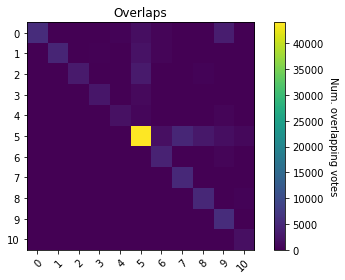

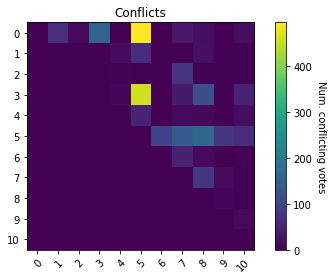

In [6]:
plot_overlap_conflict(votes, fid2clusters)

In [7]:
from nplm import PartialLabelModel

lm_cfg={'lr': 0.01,
 'epoch': 5,
 'seed': 0,
 'batch_size': 8192,
 'momentum': 0.9,
 'step_schedule': 'p',
 'step_multiplier': 0.1}

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
labelmodel = PartialLabelModel(num_classes=4,
                        fid2clusters=fid2clusters,
                        opt_cfg=lm_cfg,
                        device=device, verbose=True)

labelmodel.optimize(votes)
label_estim = labelmodel.weak_label(votes)

epoch   1:  12%|█▎        | 1/8 [00:00<00:01,  5.80it/s, Train Loss: =9.12]

Setup:  0.04872012138366699


epoch   5: 100%|██████████| 8/8 [00:01<00:00,  6.55it/s, Epoch Loss: =7.48]

Setup:  0.03786277770996094
Parallel Estimation:  0.03423476219177246


In [8]:
np.save('ag_news_soft_labels', {'sl': label_estim, 'idx': train_idx})

In [9]:
from eval import gen_stats, topk_results

data_instance_test, data_label_test = get_inst(test)

votes_test, _ = executor(plfs, data_instance_test, one_indexed=False)
accs, ps, rs = evaluator(plfs, data_label_test, pprint=True)


votes_test_filtered, label_filtered_test = votes_filter(votes_test, labels=data_label_test)


wlabels_test = labelmodel.weak_label(votes_test)

test_label_test = [elem+1 for elem in data_label_test]

_, stats = gen_stats(wlabels_test, test_label_test)
print(stats)
print(topk_results(wlabels_test, test_label_test, [1,2]))


{0: [0, 2, 3], 1: [1]}
{0: [1, 3], 1: [0, 2]}
{0: [1, 2], 1: [0, 3]}
{0: [1, 2, 3], 1: [0]}
{0: [0, 2, 3], 1: [1]}
{0: [0], 1: [1], 2: [2], 3: [2, 3]}
{0: [2, 3], 1: [0, 1]}
{0: [0, 1, 3], 1: [2]}
{0: [0, 1, 2], 1: [3]}
{0: [2, 3], 1: [0, 1]}
{0: [0, 1], 1: [2, 3]}
Name	Acc	P	R
gpe+event_title 	0.7163	0.7163	0.0329
dpw2 	0.9228	0.9228	0.0330
tech 	0.8578	0.8578	0.0230
loc_title 	0.4615	0.4615	0.0111
sports_names 	0.9565	0.9565	0.0174
Rule 5 	0.9300	0.9247	0.3408
p+gpe_title 	0.9331	0.9331	0.0349
bus_lemma 	0.8532	0.8532	0.0367
tech_terms 	0.9097	0.9097	0.0371
person+event_sen 	0.9798	0.9798	0.0447
Rule 10 	0.8760	0.8760	0.0139
Setup:  0.006567239761352539
Parallel Estimation:  0.021131277084350586
(0.5107894736842106, 0.7445193726708063, 0.5107894736842105, 0.49381807494357566)
[0.51078947 0.66144737]
